In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab
import os
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split

# Load the TensorBoard notebook extension.
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
df_shoes = pd.read_csv('post_analysis_shoes.csv')
df_shoes.shape

(8064, 18)

In [3]:
def plot_value_counts(df,column,kind,rotation=None):
    if(kind == 'barh'):
        plt.figure(figsize=(10,25))
    else:
        plt.figure(figsize=(16,5))
    (df[column].value_counts()/len(df)).plot(kind=kind,title=f"{column}")
    if(rotation):
        plt.xticks(rotation=rotation)
    plt.show()

In [4]:
popular_brands = ['olympikus', 'under_armour', 'nike', 'adidas', 'mizuno','asics','puma','fila']

df_shoes = df_shoes[df_shoes['brand'].isin(popular_brands)]

['olympikus', 'nike', 'adidas', 'asics', 'puma', 'mizuno', 'fila']


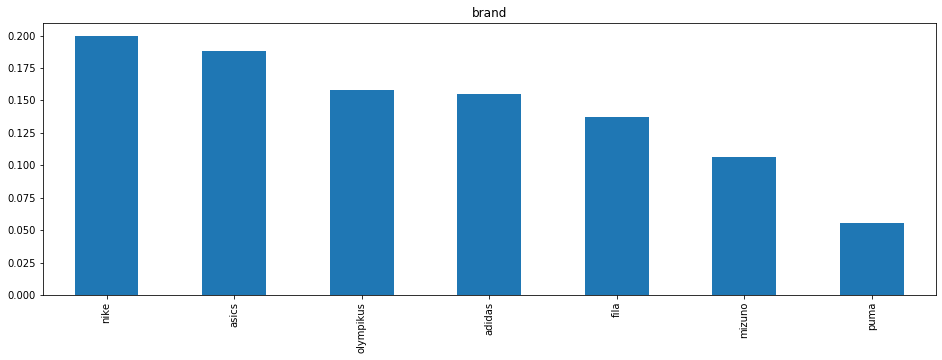

In [5]:
print(list(df_shoes['brand'].unique()))
    
plot_value_counts(df_shoes,'brand','bar')

# Preprocessing Functions

In [6]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [7]:
base_path = '/home/raphael/Documents/Projects/netshoes_ml_project/netshoes/images/'
train_image_generator = ImageDataGenerator(rescale=1./255,
                                            rotation_range=45,
                                            width_shift_range=.15,
                                            height_shift_range=.15,
                                            horizontal_flip=True,
                                            zoom_range=0.5)

validation_image_generator = ImageDataGenerator(rescale=1./255)

In [9]:
IMG_SHAPE = (380,380)
epochs = 100

checkpoint_path = './brand_model/drop50_lr00035'
efficient_net_url = "https://tfhub.dev/google/efficientnet/b4/feature-vector/1"

if(not os.path.exists(checkpoint_path)):
    os.makedirs(checkpoint_path)

    feature_extractor_layer = hub.KerasLayer(efficient_net_url,
                                         input_shape=IMG_SHAPE+(3,))
    feature_extractor_layer.trainable = False

    model = Sequential([
        feature_extractor_layer,
        Dropout(0.5),
        BatchNormalization(),
        Dense(df_shoes['brand'].nunique())
    ])
    initial_epoch = 0
else:
    model = tf.keras.models.load_model(checkpoint_path)
    initial_epoch = epochs

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1792)              17673816  
_________________________________________________________________
dropout (Dropout)            (None, 1792)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1792)              7168      
_________________________________________________________________
dense (Dense)                (None, 7)                 12551     
Total params: 17,693,535
Trainable params: 16,135
Non-trainable params: 17,677,400
_________________________________________________________________


In [10]:
df_shoes['images'] = df_shoes['images'].str.split(',')
df_data = df_shoes.explode('images')[['images','brand']]
df_data['images'] = base_path + df_data['images']
df_data.shape

(17495, 2)

In [11]:
train, valid_test = train_test_split(df_data,
                                test_size=0.15,
                                stratify=df_data['brand'].values,
                                random_state=42)

valid, test = train_test_split(valid_test,
                                test_size=0.25,
                                stratify=valid_test['brand'].values,
                                random_state=42)

train_data_gen = train_image_generator.flow_from_dataframe(train,
                                          x_col='images',
                                          y_col='brand',
                                          shuffle=True,
                                          batch_size=64,
                                          target_size=IMG_SHAPE)

val_data_gen = validation_image_generator.flow_from_dataframe(valid,
                                              x_col='images',
                                              y_col='brand',
                                              shuffle=True,
                                              batch_size=64,
                                              target_size=IMG_SHAPE)

test_data_gen = validation_image_generator.flow_from_dataframe(test,
                                              x_col='images',
                                              y_col='brand',
                                              shuffle=True,
                                              batch_size=64,
                                              target_size=IMG_SHAPE)

Found 14870 validated image filenames belonging to 7 classes.
Found 1968 validated image filenames belonging to 7 classes.
Found 657 validated image filenames belonging to 7 classes.


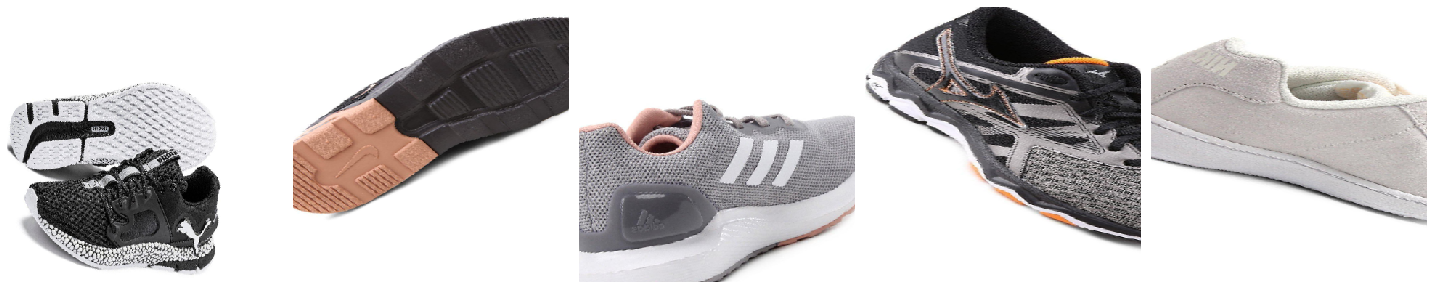

In [12]:
sample_training_images, _ = next(train_data_gen)

plot_images(sample_training_images[:5])

In [ ]:
initial_learning_rate = 0.00035

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=initial_learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

logdir = f"{checkpoint_path}/logs/scalars/"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                       save_best_only=True,
                                       monitor='val_acc',
                                       mode='max',
                                       save_weights_only=False),
    tf.keras.callbacks.TensorBoard(log_dir=logdir,profile_batch=0,update_freq='batch')
]

history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // train_data_gen.batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // val_data_gen.batch_size,
    callbacks=callbacks,
    initial_epoch=initial_epoch
)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 232 steps, validate for 30 steps
Epoch 1/100
231/232 [============================>.] - ETA: 2s - loss: 2.2988 - acc: 0.2133INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


232/232 [==============================] - 561s 2s/step - loss: 2.2978 - acc: 0.2136 - val_loss: 1.6987 - val_acc: 0.3396
Epoch 2/100
231/232 [============================>.] - ETA: 2s - loss: 1.9884 - acc: 0.2880INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


232/232 [==============================] - 554s 2s/step - loss: 1.9880 - acc: 0.2881 - val_loss: 1.5082 - val_acc: 0.4182
Epoch 3/100
231/232 [============================>.] - ETA: 2s - loss: 1.8231 - acc: 0.3348INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


232/232 [==============================] - 555s 2s/step - loss: 1.8223 - acc: 0.3349 - val_loss: 1.4079 - val_acc: 0.4609
Epoch 4/100
231/232 [============================>.] - ETA: 2s - loss: 1.7250 - acc: 0.3748INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


232/232 [==============================] - 559s 2s/step - loss: 1.7243 - acc: 0.3751 - val_loss: 1.3463 - val_acc: 0.4906
Epoch 5/100
231/232 [============================>.] - ETA: 2s - loss: 1.6539 - acc: 0.3928INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


232/232 [==============================] - 558s 2s/step - loss: 1.6544 - acc: 0.3927 - val_loss: 1.3002 - val_acc: 0.5099
Epoch 6/100
231/232 [============================>.] - ETA: 2s - loss: 1.5875 - acc: 0.4208INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


232/232 [==============================] - 557s 2s/step - loss: 1.5878 - acc: 0.4207 - val_loss: 1.2657 - val_acc: 0.5271
Epoch 7/100
231/232 [============================>.] - ETA: 2s - loss: 1.5386 - acc: 0.4379INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


232/232 [==============================] - 559s 2s/step - loss: 1.5382 - acc: 0.4380 - val_loss: 1.2398 - val_acc: 0.5385
Epoch 8/100
231/232 [============================>.] - ETA: 2s - loss: 1.4841 - acc: 0.4543INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


232/232 [==============================] - 558s 2s/step - loss: 1.4838 - acc: 0.4543 - val_loss: 1.2124 - val_acc: 0.5542
Epoch 9/100
231/232 [============================>.] - ETA: 2s - loss: 1.4606 - acc: 0.4616INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


232/232 [==============================] - 557s 2s/step - loss: 1.4614 - acc: 0.4612 - val_loss: 1.1928 - val_acc: 0.5677
Epoch 10/100
231/232 [============================>.] - ETA: 2s - loss: 1.4429 - acc: 0.4663INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


232/232 [==============================] - 557s 2s/step - loss: 1.4430 - acc: 0.4665 - val_loss: 1.1740 - val_acc: 0.5766
Epoch 11/100
231/232 [============================>.] - ETA: 2s - loss: 1.3881 - acc: 0.4906INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


232/232 [==============================] - 555s 2s/step - loss: 1.3885 - acc: 0.4906 - val_loss: 1.1592 - val_acc: 0.6010
Epoch 12/100
232/232 [==============================] - 552s 2s/step - loss: 1.3838 - acc: 0.4921 - val_loss: 1.1513 - val_acc: 0.5958
Epoch 13/100
231/232 [============================>.] - ETA: 2s - loss: 1.3627 - acc: 0.4973INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


232/232 [==============================] - 557s 2s/step - loss: 1.3622 - acc: 0.4975 - val_loss: 1.1367 - val_acc: 0.6057
Epoch 14/100
231/232 [============================>.] - ETA: 2s - loss: 1.3321 - acc: 0.5113INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


232/232 [==============================] - 560s 2s/step - loss: 1.3313 - acc: 0.5112 - val_loss: 1.1230 - val_acc: 0.6161
Epoch 15/100
231/232 [============================>.] - ETA: 2s - loss: 1.3250 - acc: 0.5152INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


232/232 [==============================] - 557s 2s/step - loss: 1.3247 - acc: 0.5152 - val_loss: 1.1155 - val_acc: 0.6240
Epoch 16/100
232/232 [==============================] - 550s 2s/step - loss: 1.3018 - acc: 0.5199 - val_loss: 1.1086 - val_acc: 0.6151
Epoch 17/100
231/232 [============================>.] - ETA: 2s - loss: 1.3039 - acc: 0.5246INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


232/232 [==============================] - 559s 2s/step - loss: 1.3039 - acc: 0.5247 - val_loss: 1.1008 - val_acc: 0.6276
Epoch 18/100
232/232 [==============================] - 552s 2s/step - loss: 1.2911 - acc: 0.5275 - val_loss: 1.0955 - val_acc: 0.6198
Epoch 19/100
232/232 [==============================] - 549s 2s/step - loss: 1.2795 - acc: 0.5337 - val_loss: 1.0902 - val_acc: 0.6214
Epoch 20/100
231/232 [============================>.] - ETA: 2s - loss: 1.2607 - acc: 0.5403INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


232/232 [==============================] - 559s 2s/step - loss: 1.2606 - acc: 0.5405 - val_loss: 1.0834 - val_acc: 0.6281
Epoch 21/100
231/232 [============================>.] - ETA: 2s - loss: 1.2716 - acc: 0.5330INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


232/232 [==============================] - 559s 2s/step - loss: 1.2720 - acc: 0.5329 - val_loss: 1.0775 - val_acc: 0.6344
Epoch 22/100
231/232 [============================>.] - ETA: 2s - loss: 1.2476 - acc: 0.5424INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


232/232 [==============================] - 557s 2s/step - loss: 1.2475 - acc: 0.5426 - val_loss: 1.0712 - val_acc: 0.6385
Epoch 23/100
232/232 [==============================] - 550s 2s/step - loss: 1.2547 - acc: 0.5453 - val_loss: 1.0700 - val_acc: 0.6297
Epoch 24/100
232/232 [==============================] - 550s 2s/step - loss: 1.2322 - acc: 0.5481 - val_loss: 1.0637 - val_acc: 0.6385
Epoch 25/100
231/232 [============================>.] - ETA: 2s - loss: 1.2308 - acc: 0.5511INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


232/232 [==============================] - 557s 2s/step - loss: 1.2302 - acc: 0.5512 - val_loss: 1.0584 - val_acc: 0.6474
Epoch 26/100
231/232 [============================>.] - ETA: 2s - loss: 1.2261 - acc: 0.5565INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


232/232 [==============================] - 557s 2s/step - loss: 1.2262 - acc: 0.5563 - val_loss: 1.0575 - val_acc: 0.6500
Epoch 27/100
232/232 [==============================] - 551s 2s/step - loss: 1.2339 - acc: 0.5523 - val_loss: 1.0520 - val_acc: 0.6432
Epoch 28/100
231/232 [============================>.] - ETA: 2s - loss: 1.2126 - acc: 0.5559INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


232/232 [==============================] - 558s 2s/step - loss: 1.2139 - acc: 0.5556 - val_loss: 1.0479 - val_acc: 0.6573
Epoch 29/100
232/232 [==============================] - 553s 2s/step - loss: 1.2160 - acc: 0.5548 - val_loss: 1.0479 - val_acc: 0.6526
Epoch 30/100
232/232 [==============================] - 553s 2s/step - loss: 1.2179 - acc: 0.5559 - val_loss: 1.0474 - val_acc: 0.6474
Epoch 31/100
232/232 [==============================] - 552s 2s/step - loss: 1.2061 - acc: 0.5636 - val_loss: 1.0440 - val_acc: 0.6500
Epoch 32/100
232/232 [==============================] - 551s 2s/step - loss: 1.2024 - acc: 0.5599 - val_loss: 1.0384 - val_acc: 0.6552
Epoch 33/100
232/232 [==============================] - 553s 2s/step - loss: 1.2087 - acc: 0.5583 - val_loss: 1.0385 - val_acc: 0.6505
Epoch 34/100
232/232 [==============================] - 551s 2s/step - loss: 1.1962 - acc: 0.5614 - val_loss: 1.0376 - val_acc: 0.6490
Epoch 35/100
231/232 [============================>.] - ETA: 2s - lo

INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


232/232 [==============================] - 558s 2s/step - loss: 1.2012 - acc: 0.5608 - val_loss: 1.0354 - val_acc: 0.6578
Epoch 36/100
232/232 [==============================] - 552s 2s/step - loss: 1.2045 - acc: 0.5596 - val_loss: 1.0391 - val_acc: 0.6557
Epoch 37/100
232/232 [==============================] - 552s 2s/step - loss: 1.1854 - acc: 0.5698 - val_loss: 1.0322 - val_acc: 0.6568
Epoch 38/100
231/232 [============================>.] - ETA: 2s - loss: 1.1962 - acc: 0.5653INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


232/232 [==============================] - 556s 2s/step - loss: 1.1949 - acc: 0.5656 - val_loss: 1.0299 - val_acc: 0.6630
Epoch 39/100
232/232 [==============================] - 554s 2s/step - loss: 1.1924 - acc: 0.5700 - val_loss: 1.0261 - val_acc: 0.6531
Epoch 40/100
232/232 [==============================] - 552s 2s/step - loss: 1.1772 - acc: 0.5673 - val_loss: 1.0263 - val_acc: 0.6531
Epoch 41/100
232/232 [==============================] - 553s 2s/step - loss: 1.1934 - acc: 0.5656 - val_loss: 1.0282 - val_acc: 0.6557
Epoch 42/100
232/232 [==============================] - 552s 2s/step - loss: 1.1901 - acc: 0.5682 - val_loss: 1.0238 - val_acc: 0.6578
Epoch 43/100
232/232 [==============================] - 552s 2s/step - loss: 1.1995 - acc: 0.5685 - val_loss: 1.0213 - val_acc: 0.6630
Epoch 44/100
232/232 [==============================] - 554s 2s/step - loss: 1.1768 - acc: 0.5744 - val_loss: 1.0210 - val_acc: 0.6589
Epoch 45/100
231/232 [============================>.] - ETA: 2s - lo

INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


232/232 [==============================] - 559s 2s/step - loss: 1.1904 - acc: 0.5684 - val_loss: 1.0175 - val_acc: 0.6677
Epoch 46/100
232/232 [==============================] - 554s 2s/step - loss: 1.1822 - acc: 0.5715 - val_loss: 1.0181 - val_acc: 0.6583
Epoch 47/100
232/232 [==============================] - 553s 2s/step - loss: 1.1722 - acc: 0.5749 - val_loss: 1.0173 - val_acc: 0.6594
Epoch 48/100
232/232 [==============================] - 553s 2s/step - loss: 1.1786 - acc: 0.5711 - val_loss: 1.0133 - val_acc: 0.6641
Epoch 49/100
232/232 [==============================] - 553s 2s/step - loss: 1.1804 - acc: 0.5745 - val_loss: 1.0212 - val_acc: 0.6531
Epoch 50/100
232/232 [==============================] - 549s 2s/step - loss: 1.1760 - acc: 0.5728 - val_loss: 1.0188 - val_acc: 0.6589
Epoch 51/100
231/232 [============================>.] - ETA: 2s - loss: 1.1738 - acc: 0.5764INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


232/232 [==============================] - 559s 2s/step - loss: 1.1742 - acc: 0.5763 - val_loss: 1.0155 - val_acc: 0.6714
Epoch 52/100
232/232 [==============================] - 553s 2s/step - loss: 1.1811 - acc: 0.5664 - val_loss: 1.0122 - val_acc: 0.6641
Epoch 53/100
232/232 [==============================] - 554s 2s/step - loss: 1.1704 - acc: 0.5729 - val_loss: 1.0123 - val_acc: 0.6620
Epoch 54/100
232/232 [==============================] - 553s 2s/step - loss: 1.1768 - acc: 0.5754 - val_loss: 1.0102 - val_acc: 0.6693
Epoch 55/100
232/232 [==============================] - 552s 2s/step - loss: 1.1740 - acc: 0.5740 - val_loss: 1.0092 - val_acc: 0.6661
Epoch 56/100
232/232 [==============================] - 551s 2s/step - loss: 1.1797 - acc: 0.5681 - val_loss: 1.0090 - val_acc: 0.6693
Epoch 57/100
232/232 [==============================] - 552s 2s/step - loss: 1.1669 - acc: 0.5745 - val_loss: 1.0085 - val_acc: 0.6641
Epoch 58/100
232/232 [==============================] - 561s 2s/step

INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


232/232 [==============================] - 578s 2s/step - loss: 1.1789 - acc: 0.5728 - val_loss: 1.0052 - val_acc: 0.6729
Epoch 65/100
232/232 [==============================] - 576s 2s/step - loss: 1.1793 - acc: 0.5714 - val_loss: 1.0060 - val_acc: 0.6620
Epoch 66/100
232/232 [==============================] - 573s 2s/step - loss: 1.1698 - acc: 0.5710 - val_loss: 1.0052 - val_acc: 0.6635
Epoch 67/100
232/232 [==============================] - 572s 2s/step - loss: 1.1681 - acc: 0.5830 - val_loss: 1.0053 - val_acc: 0.6646
Epoch 68/100
232/232 [==============================] - 575s 2s/step - loss: 1.1646 - acc: 0.5767 - val_loss: 1.0049 - val_acc: 0.6724
Epoch 69/100
232/232 [==============================] - 570s 2s/step - loss: 1.1615 - acc: 0.5825 - val_loss: 1.0053 - val_acc: 0.6693
Epoch 70/100
232/232 [==============================] - 574s 2s/step - loss: 1.1705 - acc: 0.5774 - val_loss: 1.0044 - val_acc: 0.6693
Epoch 71/100
232/232 [==============================] - 571s 2s/step

INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


232/232 [==============================] - 568s 2s/step - loss: 1.1723 - acc: 0.5754 - val_loss: 1.0024 - val_acc: 0.6734
Epoch 74/100
232/232 [==============================] - 554s 2s/step - loss: 1.1686 - acc: 0.5782 - val_loss: 1.0031 - val_acc: 0.6687
Epoch 75/100
231/232 [============================>.] - ETA: 2s - loss: 1.1692 - acc: 0.5728INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_lr0001/assets


232/232 [==============================] - 561s 2s/step - loss: 1.1689 - acc: 0.5729 - val_loss: 0.9998 - val_acc: 0.6781
Epoch 76/100
232/232 [==============================] - 556s 2s/step - loss: 1.1651 - acc: 0.5738 - val_loss: 1.0009 - val_acc: 0.6682
Epoch 77/100
232/232 [==============================] - 558s 2s/step - loss: 1.1646 - acc: 0.5763 - val_loss: 0.9993 - val_acc: 0.6661
Epoch 78/100
232/232 [==============================] - 557s 2s/step - loss: 1.1765 - acc: 0.5793 - val_loss: 0.9981 - val_acc: 0.6698
Epoch 79/100
232/232 [==============================] - 567s 2s/step - loss: 1.1610 - acc: 0.5788 - val_loss: 1.0014 - val_acc: 0.6609
Epoch 80/100
232/232 [==============================] - 572s 2s/step - loss: 1.1575 - acc: 0.5810 - val_loss: 0.9964 - val_acc: 0.6734
Epoch 81/100
232/232 [==============================] - 570s 2s/step - loss: 1.1563 - acc: 0.5840 - val_loss: 0.9987 - val_acc: 0.6781
Epoch 82/100
232/232 [==============================] - 580s 2s/step

In [ ]:
model = tf.keras.models.load_model(checkpoint_path)

class_names = sorted(train_data_gen.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])

image_batch, label_batch = test_data_gen.next()

predicted_batch = model.predict(image_batch)
real_id = np.argmax(label_batch,axis=-1)
real_label_batch = class_names[real_id]
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)

plt.figure(figsize=(15,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
    plt.subplot(4,5,n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(f"Predicted : {predicted_label_batch[n].title()}\nTrue: {real_label_batch[n].title()}",
              color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")
plt.show()

In [ ]:
# Evaluation on whole val set
model.evaluate(val_data_gen)

# Evaluation on whole test set
model.evaluate(test_data_gen)